In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
from jax import jit, grad
import jax.numpy as jnp
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools

In [3]:
def MZ_plus():
    g = jqt.basis(2,0)
    plus = g 
    pp = plus @ plus.dag()
    kmap = jqt.QarrayArray.create([2*pp])

    return jqtc.Gate.create(
        2, 
        name="MZplus",
        gen_KM = lambda params: kmap,
        num_modes=1
    )

In [9]:
def run_circuit_N(params, N):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas_re = params[2]
    betas_im = params[3]
    betas = betas_re + 1j*betas_im
    
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)-1):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
    
    cirq.append(jqtc.Rx(gammas_x[-1]), 0)
    cirq.append(jqtc.Ry(gammas_y[-1]), 0)
    cirq.append(jqtc.D(N, betas[-1]), 1)

    cirq.append(MZ_plus(), 0)

    initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
    res = jqtc.simulate(cirq, initial_state, mode="kraus")

    return res[-1][-1].unit()

run_circuit = lambda params: run_circuit_N(params, 20)
run_circuit_larger = lambda params: run_circuit_N(params, 40)

Text(62.44444444444453, 0.5, 'Im[α]')

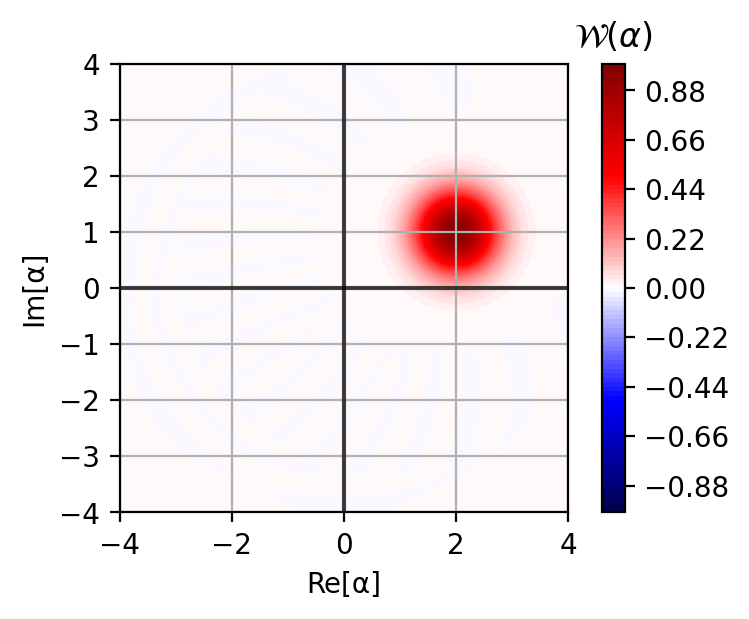

In [13]:
params = jnp.array([[0.0,0.0], [0.0,0.0], [4,0.0], [0.0,1.0]])

final_state = run_circuit(
    params
)

state = final_state
pts = jnp.linspace(-4,4, 101)
ax, _ = jqt.plot_wigner(jqt.ptrace(state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

In [14]:
def fid_metric(params):
    N = 20
    # target_state = (jqt.coherent(N,-2) + jqt.coherent(N,2)).unit()
    target_state = jqt.basis(N,1) 
    prepared_state = jqt.ptrace(run_circuit(params),1)
    return jnp.real(jqt.overlap(target_state, prepared_state).data[0][0])

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0,))

def metric(params):
    fids = fid_metric_vmap(params)
    losses = jnp.log(1 - fids)
    avg_loss = jnp.average(losses)
    return avg_loss

metric(jnp.array([params,2*params]))

Array(-0.01713524, dtype=float64)

# Batch Gradient Descent

In [16]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Parameters
key = jax.random.PRNGKey(0)  # Initialize a random key
B = 100 # Batch size
num_blocks = 1
lower_bounds = jnp.array([-1, -1, -3, -3])  # Define the lower bounds for each axis
upper_bounds = jnp.array([1, 1, 3, 3])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks+1), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params).block_until_ready()

1.83 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
55.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
162 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
62.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)


params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []

epochs = 200
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params))
  metric, grads = metric_val_and_grad(params)
  metric_history.append(metric)

  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

params_history = jnp.array(params_history)
fids_history = jnp.array(fids_history)
metric_history = jnp.array(metric_history)

100%|██████████| 200/200 [00:39<00:00,  5.08it/s]


In [20]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = j
jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\shanj\AppData\Local\Temp\ipykernel_22244\4268492758.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
C:\Users\shanj\AppData\Local\Temp\ipykernel_22244\4268492758.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")


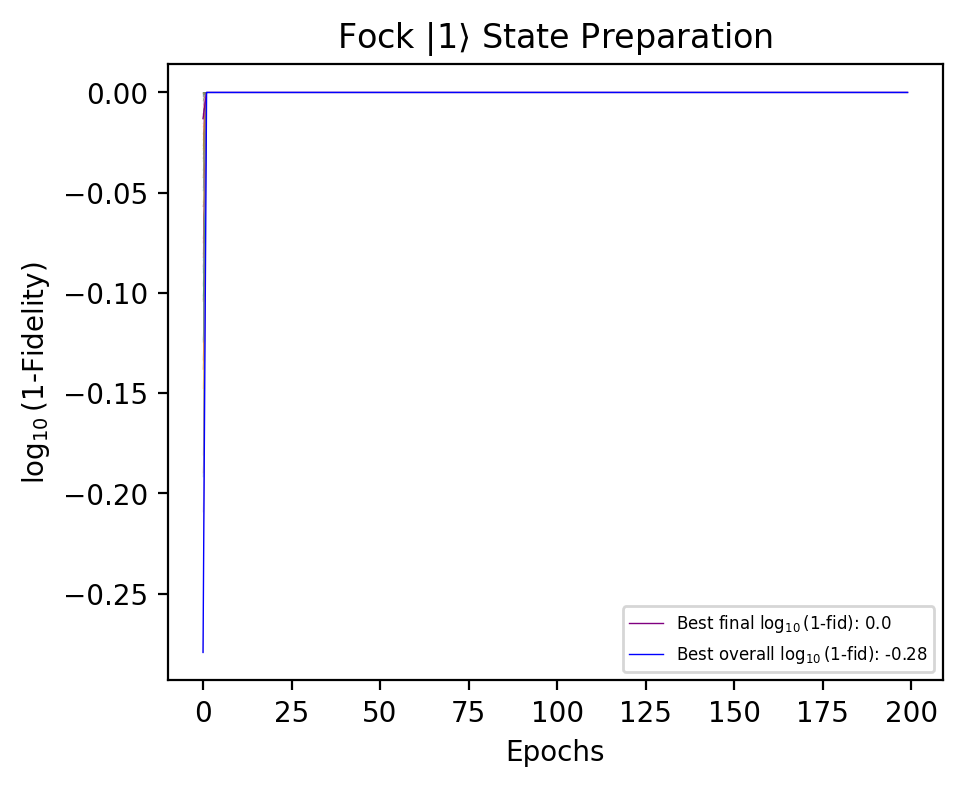

In [21]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(r"Fock $|1\rangle$ State Preparation")
ax.legend(fontsize=6)

Best parameters: 
 [[ 0.51000259]
 [ 0.61176554]
 [-1.98988232]]


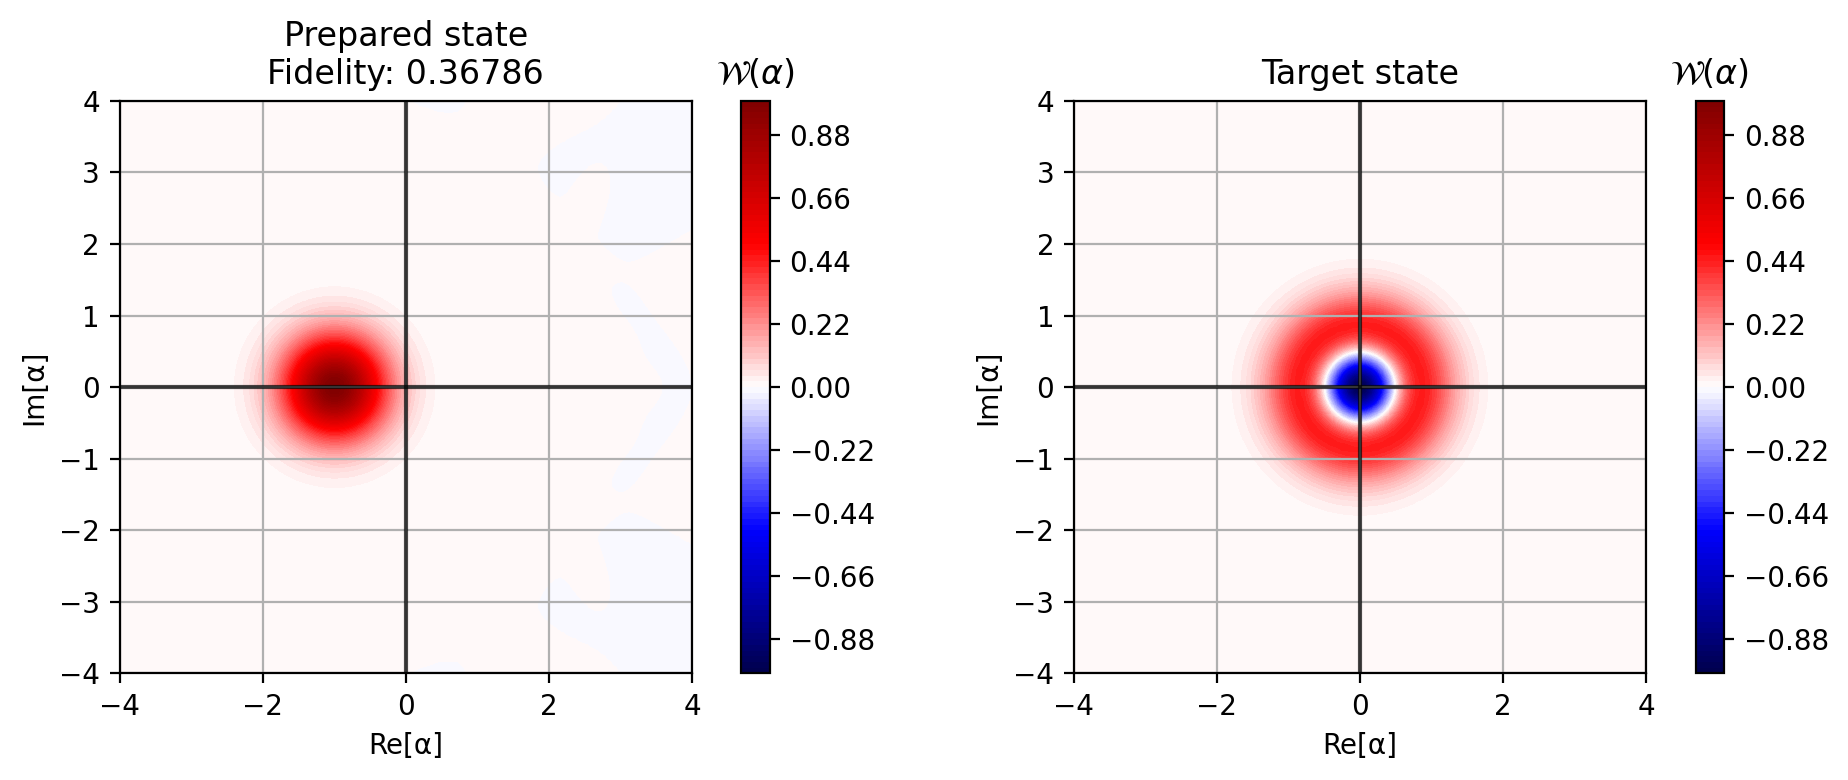

In [13]:
best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
print("Best parameters: \n", best_params)


fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

state = run_circuit_larger(best_params)
pts = jnp.linspace(-4,4, 101)
ax, _ = jqt.plot_wigner(jqt.ptrace(state,1), pts, ax=axs[0])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Prepared state\n" + f"Fidelity: {best_fid:.5f}")

state = jqt.basis(40,1)
pts = jnp.linspace(-4,4, 101)
ax, _ = jqt.plot_wigner(state, pts, ax=axs[1])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Target state")

fig.tight_layout()